# Testing Vector index and search with Haystack

In [1]:
# Make sure you have a GPU running
! nvidia-smi

Sun Jul  4 15:01:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.31       Driver Version: 465.31       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P0    20W /  N/A |     55MiB /  5934MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import pandas as pd
from haystack.document_store.elasticsearch import OpenDistroElasticsearchDocumentStore
from haystack.retriever import EmbeddingRetriever
from haystack.reader.transformers import TransformersReader
from haystack.pipeline import ExtractiveQAPipeline
from haystack.utils import print_answers

from src import PROJECT_ROOT

07/04/2021 15:01:05 - INFO - faiss.loader -   Loading faiss with AVX2 support.
07/04/2021 15:01:05 - INFO - faiss.loader -   Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
07/04/2021 15:01:05 - INFO - faiss.loader -   Loading faiss.
07/04/2021 15:01:05 - INFO - faiss.loader -   Successfully loaded faiss.
07/04/2021 15:01:05 - INFO - farm.modeling.prediction_head -   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [3]:
from typing import List, Optional
from haystack import Document
from haystack.reader.base import BaseReader

class CrossEncoderReRanker(BaseReader):
    """
    A re-ranker based on a BERT Cross-Encoder. The query and a candidate result are passed
    simoultaneously to the trasnformer network, which then output a single score between
    0 and 1 indicating how relevant the document is for the given query. Read the article
    in https://www.sbert.net/examples/applications/retrieve_rerank/README.html for further
    details.
    """

    def __init__(
        self,
        cross_encoder: str = "cross-encoder/ms-marco-TinyBERT-L-6",
        use_gpu: int = True,
        top_k: int = 10
    ):
        """
        :param cross_encoder: Local path or name of cross-encoder model in Hugging Face's model hub such as ``'cross-encoder/ms-marco-TinyBERT-L-6'``
        :param use_gpu: If < 0, then use cpu. If >= 0, this is the ordinal of the gpu to use
        :param top_k: The maximum number of answers to return
        """

        # # save init parameters to enable export of component config as YAML
        # self.set_config(
        #     cross_encoder=cross_encoder, use_gpu=use_gpu, top_k=top_k
        # )

        self.top_k = top_k

        try:
            from sentence_transformers import CrossEncoder
        except ImportError:
            raise ImportError("Can't find package `sentence-transformers` \n"
                              "You can install it via `pip install sentence-transformers` \n"
                              "For details see https://github.com/UKPLab/sentence-transformers ")
        # pretrained embedding models coming from: https://github.com/UKPLab/sentence-transformers#pretrained-models
        if use_gpu:
            device = "cuda"
        else:
            device = "cpu"
        self.cross_encoder = CrossEncoder(cross_encoder, device=device)

    def predict(self, query: str, documents: List[Document], top_k: Optional[int] = None):
        """
        Use the cross-encoder to find answers for a query in the supplied list of Document.
        Returns dictionaries containing answers sorted by (desc.) probability.
        Example:
         ```python
            |{
            |    'query': 'What is the capital of the United States?',
            |    'answers':[
            |                 {'answer': 'Washington, D.C. (also known as simply Washington or D.C., 
            |                  and officially as the District of Columbia) is the capital of 
            |                  the United States. It is a federal district. The President of 
            |                  the USA and many major national government offices are in the 
            |                  territory. This makes it the political center of the United 
            |                  States of America.',
            |                 'score': 0.717,
            |                 'document_id': 213
            |                 },...
            |              ]
            |}
         ```
        :param query: Query string
        :param documents: List of Document in which to search for the answer
        :param top_k: The maximum number of answers to return
        :return: Dict containing query and answers
        """
        if top_k is None:
            top_k = self.top_k

        # Score every document with the cross_encoder
        cross_inp = [[query, doc.text] for doc in documents]
        cross_scores = self.cross_encoder.predict(cross_inp)
        answers = [
            {
                'answer': documents[idx].text, 
                'score': cross_scores[idx],
                'document_id': documents[idx].id,
                'meta': documents[idx].meta
            }
            for idx in range(len(documents))
        ]

        # Sort answers by the cross-encoder scores and select top-k
        answers = sorted(
            answers, key=lambda k: k["score"], reverse=True
        )
        answers = answers[:top_k]

        results = {"query": query,
                   "answers": answers}

        return results

    def predict_batch(self, query_doc_list: List[dict], top_k: Optional[int] = None,  batch_size: Optional[int] = None):
        raise NotImplementedError("Batch prediction not yet available in CrossEncoderReRanker.")

## Document Store

Haystack finds answers to queries within the documents stored in a `DocumentStore`. In this example we will be using `OpenDistroElasticsearchDocumentStore` for its reliablity and compatibility with dense vector queries.

### Start an Elasticsearch server
You can start Elasticsearch on your local machine instance using Docker. If Docker is not readily available in your environment (eg., in Colab notebooks), then you can manually download and execute Elasticsearch from source.

In [4]:
# Recommended: Start Elasticsearch using Docker
#! docker run -d -p 9200:9200 -p 9600:9600 -e "discovery.type=single-node" amazon/opendistro-for-elasticsearch:1.13.2

In [5]:
# Connect to ODElasticsearch instance (needs to be changed for security reasons)
document_store = OpenDistroElasticsearchDocumentStore(host='odfe-node1', 
                                                      username='admin', 
                                                      password='admin', 
                                                      scheme='https', 
                                                      verify_certs=False,
                                                      similarity='cosine',
                                                      return_embedding=True)
print(f"Document Store has {document_store.get_document_count()} documents.")

/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/http_urllib3.py:206: UserWarning: Connecting to https://odfe-node1:9200 using SSL with verify_certs=False is insecure.
  % self.host
/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1006: InsecureRequestWarning: Unverified HTTPS request is being made to host 'odfe-node1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
07/04/2021 15:01:06 - INFO - elasticsearch -   HEAD https://odfe-node1:9200/ [status:200 request:0.039s]
/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1006: InsecureRequestWarning: Unverified HTTPS request is being made to host 'odfe-node1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
07/04/2021 15:01:06 - WARNING - elasticsearch -   PUT https://odfe-node1:9200/document

Document Store has 336389 documents.


## Preprocessing and writing documents

Haystack provides a customizable pipeline for:
 - converting files into texts
 - cleaning texts
 - splitting texts
 - writing them to a Document Store

In this example, we load the news articles from NewsAPI, apply a basic cleaning function, and index them in ODElasticsearch.

In [6]:
data_file = os.path.join(PROJECT_ROOT, "data","processed", "newsapi_docs.csv")
df = pd.read_csv(data_file, header=None, names=['collection', 'datetime', 'topic', 'original', 'split', 'clean'])
df.head()

,collection,datetime,topic,original,split,clean
0,top_headlines,2021-04-18T06:25:29,sports,Barcelona Scores Four Goals in 12-Minute Span to Win Copa del Rey - Sports I...,train,barcelona score four goal 12minut span win copa del rey sport illustr barcel...
1,top_headlines,2021-03-25T22:25:31,business,"Olive Garden parent's earnings beat, forecasts stronger sales next quarter -...",train,oliv garden parent earn beat forecast stronger sale next quarter cnbc darden...
2,everything,2021-03-03T14:25:31,technology,A new RPG from the creator of Final Fantasy is coming to Apple Arcade It’s d...,train,new rpg creator final fantasi come appl arcad diorama meet final fantasi fir...
3,everything,2021-04-15T06:25:30,technology,These are the spectacular winners of the Sony World Photography Awards The w...,train,spectacular winner soni world photographi award winner soni world photograph...
4,top_headlines,2021-03-11T14:25:30,sports,Sam Darnold Landing Spots: Trade partners for the Jets QB - Pro Football Net...,train,sam darnold land spot trade partner jet qb pro footbal network nfl continu w...


<AxesSubplot:>

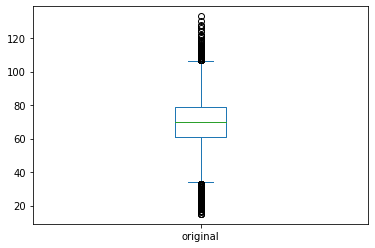

In [7]:
# Checking number of word distribution
df['original'].apply(lambda x: len(x.strip().split(" "))).plot(kind='box')

In [8]:
# We don't need to split since the texts are short
dicts = []
for _, data in df.iterrows():
    dicts.append({'text': data['original'], 'meta': data[['collection', 'datetime', 'topic']].to_dict()})
    
# Let's have a look at the first 3 entries:
print(dicts[:3])

# Now, let's write the dicts containing documents to our DB.
# document_store.write_documents(dicts)

[{'text': 'Barcelona Scores Four Goals in 12-Minute Span to Win Copa del Rey - Sports Illustrated Barcelona dominated Athletic Bilbao on Saturday by a 4–0 score, with two goals scored by Lionel Messi. Barcelona dominated Athletic Bilbao on Saturday 4–0 to win the Copa del Rey with all four goals coming in the span of just 12 minutes.\xa0Forward Antoine Griezmann was the first to draw blood in the 6', 'meta': {'collection': 'top_headlines', 'datetime': '2021-04-18T06:25:29', 'topic': 'sports'}}, {'text': "Olive Garden parent's earnings beat, forecasts stronger sales next quarter - CNBC Darden Restaurants stock surges after the company reported quarterly\xa0earnings\xa0that topped analysts' expectations. Darden Restaurants on Thursday reported quarterly\xa0earnings\xa0that topped analysts' expectations as customers visited Olive Garden and its other chains more than expected.The company is forecasting th", 'meta': {'collection': 'top_headlines', 'datetime': '2021-03-25T22:25:31', 'topic'

## Initalize Retriever and Reader

### Retriever

Retrievers help narrowing down the scope for the Reader to smaller units of text where a given question could be answered.
They use some simple but fast algorithm.

We use the EmbeddingRetriever with SBERT.

In [9]:
# TODO: Create custom retriever for performing semantic search with binary filters 
# (e.g. I want only documents with the word "crisis")

# Pre-trained SBERT retrieval Bi-Encoder
emb_retriever = EmbeddingRetriever(document_store=document_store, embedding_model="sentence-transformers/msmarco-distilbert-base-v2")

# Adds new embeddings in the the document store using the retriever encodings
document_store.update_embeddings(emb_retriever, update_existing_embeddings=False)

07/04/2021 15:01:42 - INFO - haystack.retriever.dense -   Init retriever using embeddings of model sentence-transformers/msmarco-distilbert-base-v2
07/04/2021 15:01:42 - INFO - farm.utils -   Using device: CUDA 
07/04/2021 15:01:42 - INFO - farm.utils -   Number of GPUs: 1
07/04/2021 15:01:42 - INFO - farm.utils -   Distributed Training: False
07/04/2021 15:01:42 - INFO - farm.utils -   Automatic Mixed Precision: None
07/04/2021 15:01:52 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
07/04/2021 15:01:52 - INFO - farm.utils -   Using device: CUDA 
07/04/2021 15:01:52 - INFO - farm.utils -   Number of GPUs: 1
07/04/2021 15:01:52 - INFO - farm.utils -   Distributed Training: False
07/04/2021 15:01:52 - INFO - farm.utils -   Automatic Mixed Precision: None
07/04/2021 15:01:52 - INFO - haystack.document_store.elasticsearch -   Updating embeddings for new docs without embeddings ...
/usr/lib/python3/dist-packages/urllib3/con

### Reader

A Reader scans the texts returned by retrievers in detail and extracts the k best answers. They are based
on powerful, but slower deep learning models.

Haystack currently supports Readers based on the frameworks FARM and Transformers.
With both you can either load a local model or one from Hugging Face's model hub (https://huggingface.co/models).

#### CrossEncoderReRanker

We create a custom Reader called CrossEncoderReRanker that applies a BERT cross-encoder between the query and each document returned by the retriever.

In [10]:
# reader = TransformersReader(model_name_or_path="distilbert-base-uncased-distilled-squad", tokenizer="distilbert-base-uncased", use_gpu=-1)
reader = CrossEncoderReRanker()

### Pipeline

With a Haystack `Pipeline` you can stick together your building blocks to a search pipeline.
Under the hood, `Pipelines` are Directed Acyclic Graphs (DAGs) that you can easily customize for your own use cases.
To speed things up, Haystack also comes with a few predefined Pipelines. One of them is the `ExtractiveQAPipeline` that combines a retriever and a reader to answer our questions.
You can learn more about `Pipelines` in the [docs](https://haystack.deepset.ai/docs/latest/pipelinesmd).

In [11]:
pipe = ExtractiveQAPipeline(reader, emb_retriever)

## Voilà! Ask a question!

In [12]:
# You can configure how many candidates the reader and retriever shall return
# The higher top_k_retriever, the better (but also the slower) your answers. 
prediction = pipe.run(query="Brexit", 
                      top_k_retriever=100, top_k_reader=10)

07/04/2021 15:01:58 - WARNING - farm.data_handler.processor -   Currently no support in Processor for returning problematic ids
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  8.46 Batches/s]
/usr/lib/python3/dist-packages/urllib3/connectionpool.py:1006: InsecureRequestWarning: Unverified HTTPS request is being made to host 'odfe-node1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
07/04/2021 15:01:58 - INFO - elasticsearch -   POST https://odfe-node1:9200/document/_search [status:200 request:0.307s]


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
print_answers(prediction)

{   'answers': [   {   'answer': "Brexit is just weeks old, and it's already "
                                 'threatening fragile political stability in '
                                 "Northern Ireland Northern Ireland's Brexit "
                                 'backlash has arrived. It snuck in through a '
                                 'side door the European Union rashly opened '
                                 'last week when it threatened to trigger the '
                                 'most contentious part of the Brexit deal, '
                                 'article 16 of the Northern Ireland protocol, '
                                 "and has quickly (CNN)Northern Ireland's "
                                 'Brexit backlash has arrived. It snuck in '
                                 'through a side door the European Union '
                                 'rashly opened last week when it threatened '
                                 'to trigger the most cont